# Image classification from scratch
Kaggle Cats vs Dogs binary classification

#### **Imporiting Packagest** 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#### **Loading Data**

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  74.3M      0  0:00:10  0:00:10 --:--:-- 81.0M


In [ ]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls # or !dir This command is used to access the list of contents in current directory

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [ ]:
!ls PetImages

Cat  Dog


In [ ]:
!dir

kagglecatsanddogs_3367a.zip  PetImages	    sample_data
MSR-LA\ -\ 3467.docx	     readme[1].txt


# Filtering out correpted images

In [ ]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb") # open the file fpath for read mode (r) with binary I/O (b).
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
# https://stackoverflow.com/questions/62220855/tensorflow-removing-jfif explaination
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


# Generate a Dataset

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2, # sets 80% for training set. but argumente is given as validation_split
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2, # sets 20% split for validation set
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


# Visualizing the data
Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat".

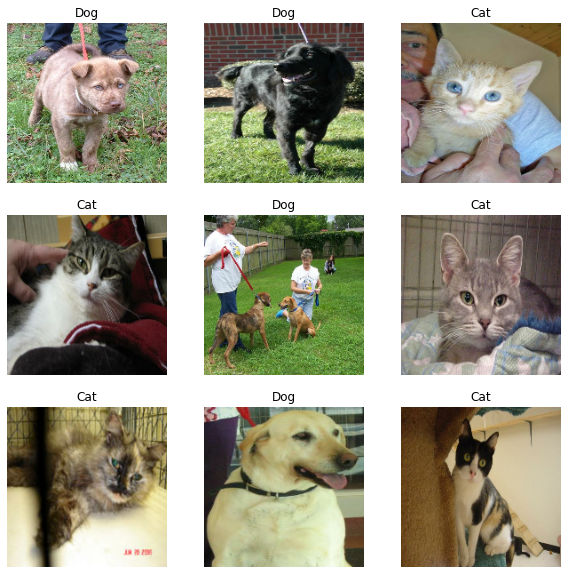

In [ ]:
import matplotlib.pyplot as plt

class_label = ["Cat", "Dog"]
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
  
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8")) # dtype is uint8 for 8-bit images (0-255
    plt.title(class_label[int(labels[i])])
    plt.grid(False)
    plt.axis("off")

# Using image data augmentation
 This helps expose the model to different aspects of the training data while slowing down overfitting.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

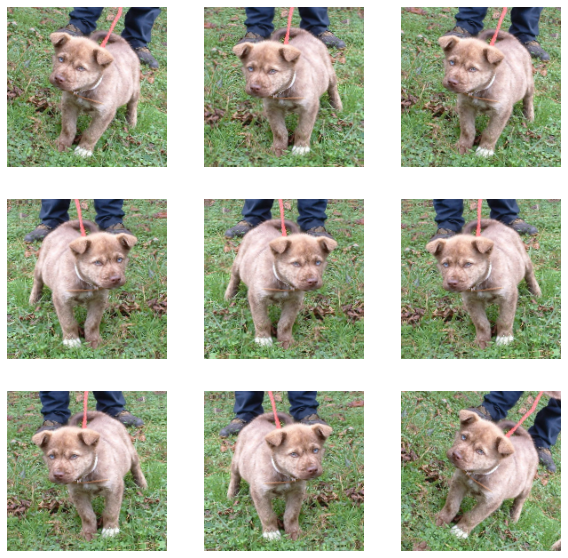

In [ ]:
plt.figure(figsize = (10,10))
for image, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    augmented_image = data_augmentation(images)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis('off')

# Standardizing the data
    
  Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

# Configuring the dataset for performance
Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`.prefetch()` overlaps data preprocessing and model execution while training.



In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Build a model

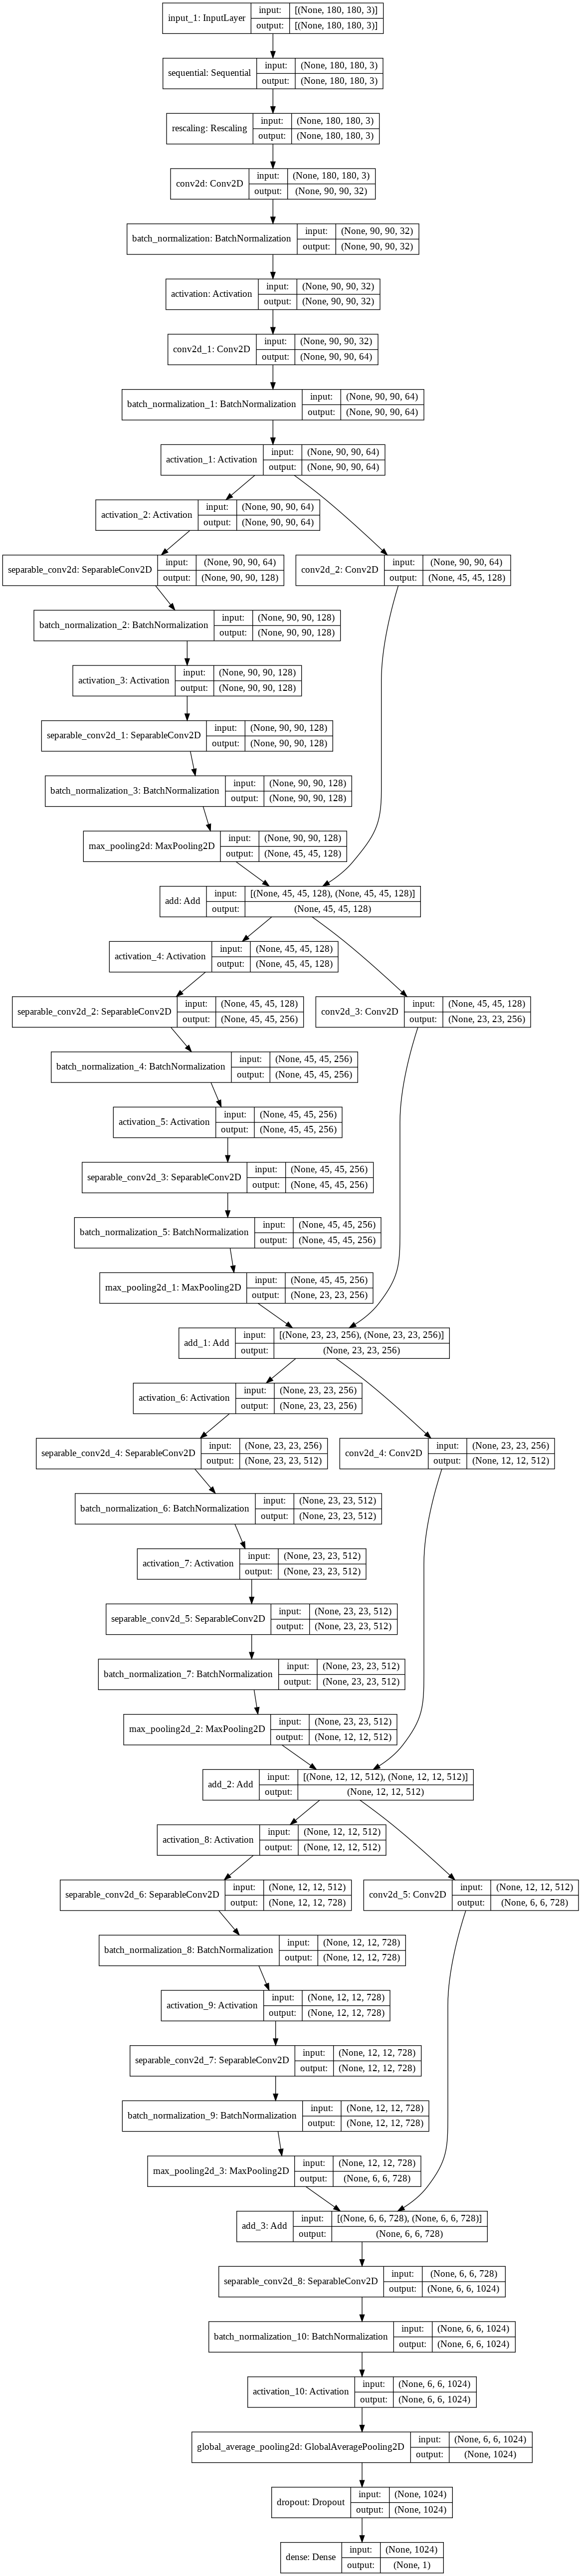

In [ ]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape = input_shape)
  x = data_augmentation(inputs)
  x = layers.experimental.preprocessing.Rescaling(1.0/255)(x)
  x = layers.Conv2D(filters = 32,kernel_size = 3,
                    strides = 2, padding = "same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(64, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x
  # idea behind saperableconv2D https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728#:~:text=This%20is%20the%20type%20of,layers.&text=Similar%20to%20the%20spatial%20separable,convolution%20and%20the%20pointwise%20convolution.
  
  for size in [128,256,512,728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size , 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides = 2, padding = "same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation)
    x = layers.add([x, residual])
    previous_block_activation = x
  
  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)

  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  
  else:
    activation = "softmax"
    units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


# Train the model

In [ ]:
epochs = 50

callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 192s 267ms/step - loss: 0.6229 - accuracy: 0.6646 - val_loss: 0.8297 - val_accuracy: 0.5681


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
586/586 [==============================] - 157s 267ms/step - loss: 0.4669 - accuracy: 0.7802 - val_loss: 0.4137 - val_accuracy: 0.8150
Epoch 3/50
586/586 [==============================] - 157s 268ms/step - loss: 0.3597 - accuracy: 0.8402 - val_loss: 0.4508 - val_accuracy: 0.7742
Epoch 4/50
586/586 [==============================] - 156s 267ms/step - loss: 0.2789 - accuracy: 0.8791 - val_loss: 0.2805 - val_accuracy: 0.8765
Epoch 5/50
586/586 [==============================] - 157s 267ms/step - loss: 0.2361 - accuracy: 0.9019 - val_loss: 0.3498 - val_accuracy: 0.8590
Epoch 6/50
586/586 [==============================] - 157s 267ms/step - loss: 0.2124 - accuracy: 0.9103 - val_loss: 0.7121 - val_accuracy: 0.7262
Epoch 7/50
586/586 [==============================] - 157s 267ms/step - loss: 0.1932 - accuracy: 0.9195 - val_loss: 0.3961 - val_accuracy: 0.8204
Epoch 8/50
586/586 [==============================] - 157s 268ms/step - loss: 0.1722 - accuracy: 0.9278 - val_loss: 0.1433 -

# Run inference on new data

This image is 63.25 percent cat and 36.75 percent dog.


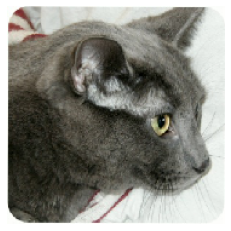

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
plt.figure()
plt.imshow(img)
plt.axis("off")
predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)